In [1]:
# Core imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path

# Qiskit imports
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QuantumVolume
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit.transpiler import PassManager

# Configuration (MUST be loaded first)
sys.path.append('..')
from config_loader import load_config, get_config

# Load configuration as the SINGLE SOURCE OF TRUTH
# Config file is in parent directory
config = load_config('../config.yaml')
print("🔧 Configuration loaded successfully!")
config.print_config_summary()

# Local imports
from layout_opt.heavyhex_layout import GreedyCommunityLayout
from layout_opt.utils import load_benchmarks, transpile_and_score

print(f"\n✅ Qiskit version: {qiskit.__version__}")
print(f"✅ NumPy version: {np.__version__}")
print(f"✅ NetworkX version: {nx.__version__}")
print(f"✅ All imports successful!")


🔧 Configuration loaded successfully!
🔧 Configuration Summary
Experiment: heavy_hex_optimization
Description: Layout optimization for IBM Heavy-Hex backends targeting 25% CX reduction
Seed: 42

Backend: FakeBrisbane (127 qubits)

Benchmark suite: quantum_volume
Circuit sizes: [15, 25, 60]

Layout algorithm: simple

Targets:
  CX reduction: ≥25.0%

✅ Qiskit version: 1.2.4
✅ NumPy version: 1.24.4
✅ NetworkX version: 3.1
✅ All imports successful!


## Backend Setup

Initialize the IBM Heavy-Hex backend for testing:


In [2]:
# Initialize backend using config (NO HARDCODED BACKEND!)
backend_name = config.get_backend_name()
print(f"🎯 Using backend from config: {backend_name}")

# Get backend dynamically based on config
if backend_name == "FakeBrisbane":
    from qiskit_ibm_runtime.fake_provider import FakeBrisbane
    backend = FakeBrisbane()
elif backend_name == "FakePerth":
    from qiskit_ibm_runtime.fake_provider import FakePerth
    backend = FakePerth()
elif backend_name == "FakeSherbrooke":
    from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
    backend = FakeSherbrooke()
else:
    raise ValueError(f"Unsupported backend: {backend_name}")

# Get backend configuration
backend_config = backend.configuration()

print(f"Backend name:      {backend.name}")
print(f"Number of qubits:  {backend_config.n_qubits}")
print(f"Coupling map:      {len(backend_config.coupling_map)} edges")
print(f"Basis gates:       {backend_config.basis_gates}")

print(f"\n✅ Backend initialized from config!")
print(f"   Using seed: {config.get_seed()}")
print(f"   Optimization level: {config.get_optimization_level()}")
print("   Ready for Heavy-Hex layout optimization…")

🎯 Using backend from config: FakeBrisbane
Backend name:      fake_brisbane
Number of qubits:  127
Coupling map:      144 edges
Basis gates:       ['ecr', 'id', 'rz', 'sx', 'x']

✅ Backend initialized from config!
   Using seed: 42
   Optimization level: 3
   Ready for Heavy-Hex layout optimization…


In [3]:
# Import topology analyzer
from layout_opt.distance import HeavyHexTopologyAnalyzer

print("🔬 Heavy-Hex Topology Analysis")
print("=" * 50)

# Initialize analyzer with backend and config
topology_analyzer = HeavyHexTopologyAnalyzer(backend, config)

# Run comprehensive analysis
print("🔄 Analyzing Heavy-Hex topology...")
analysis_results = topology_analyzer.analyze_topology()

# Display results
summary = analysis_results['analysis_summary']
topology_stats = analysis_results['topology_stats']

print(f"\n📊 Topology Analysis Results:")
print(f"   Backend: {analysis_results['backend_name']}")
print(f"   Total qubits: {topology_stats['n_qubits']}")
print(f"   Total edges: {topology_stats['n_edges']}")
print(f"   Average degree: {topology_stats['avg_degree']:.2f}")
print(f"   Diameter: {topology_stats['diameter']}")
print(f"   Connected: {topology_stats['is_connected']}")

print(f"\n🔍 Heavy-Hex Structure Analysis:")
print(f"   Hex clusters found: {summary['n_hex_clusters']}")
print(f"   Cluster centers: {summary['n_cluster_centers']}")
print(f"   Bridge qubits: {summary['n_bridge_qubits']}")
print(f"   Boundary qubits: {summary['n_boundary_qubits']}")
print(f"   Avg cluster size: {summary['avg_cluster_size']:.1f}")
print(f"   Topology efficiency: {summary['topology_efficiency']:.3f}")

print(f"\n🎨 Degree Distribution:")
for degree, count in topology_stats['degree_distribution'].items():
    print(f"   Degree {degree}: {count} qubits")

# Cache analysis for layout optimization
print(f"\n💾 Topology analysis cached for layout optimization")
print(f"✅ Ready for community detection and layout assignment!")


🔬 Heavy-Hex Topology Analysis
🔄 Analyzing Heavy-Hex topology...

📊 Topology Analysis Results:
   Backend: fake_brisbane
   Total qubits: 127
   Total edges: 144
   Average degree: 2.27
   Diameter: 26
   Connected: True

🔍 Heavy-Hex Structure Analysis:
   Hex clusters found: 24
   Cluster centers: 24
   Bridge qubits: 6
   Boundary qubits: 2
   Avg cluster size: 7.0
   Topology efficiency: 0.091

🎨 Degree Distribution:
   Degree 2: 89 qubits
   Degree 3: 36 qubits
   Degree 1: 2 qubits

💾 Topology analysis cached for layout optimization
✅ Ready for community detection and layout assignment!


### Topology Visualization

Let's create visualizations of the Heavy-Hex topology structure:


🎨 Creating topology visualizations...
📈 Special Qubits Found:
   Cluster centers: [4, 8, 12, 22, 26, 30, 39, 43, 47, 49, 60, 64, 62, 77, 79, 83, 85, 87, 96, 100, 104, 118, 114, 122]
   Bridge qubits: [19, 36, 57, 67, 90, 107]
   Boundary qubits: [13, 113]

🔶 Hex Clusters Found:
   Cluster 1: [2, 3, 4, 5, 6, 15, 22]
   Cluster 2: [6, 7, 8, 9, 10, 16, 26]
   Cluster 3: [9, 10, 11, 12, 13, 17, 30]
   Cluster 4: [4, 15, 20, 21, 22, 23, 24]
   Cluster 5: [8, 16, 24, 25, 26, 27, 28]
   ... and 19 more clusters
Creating topology visualizations..
Backend provided: fake_brisbane
Backend config attributes: ['__annotations__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '

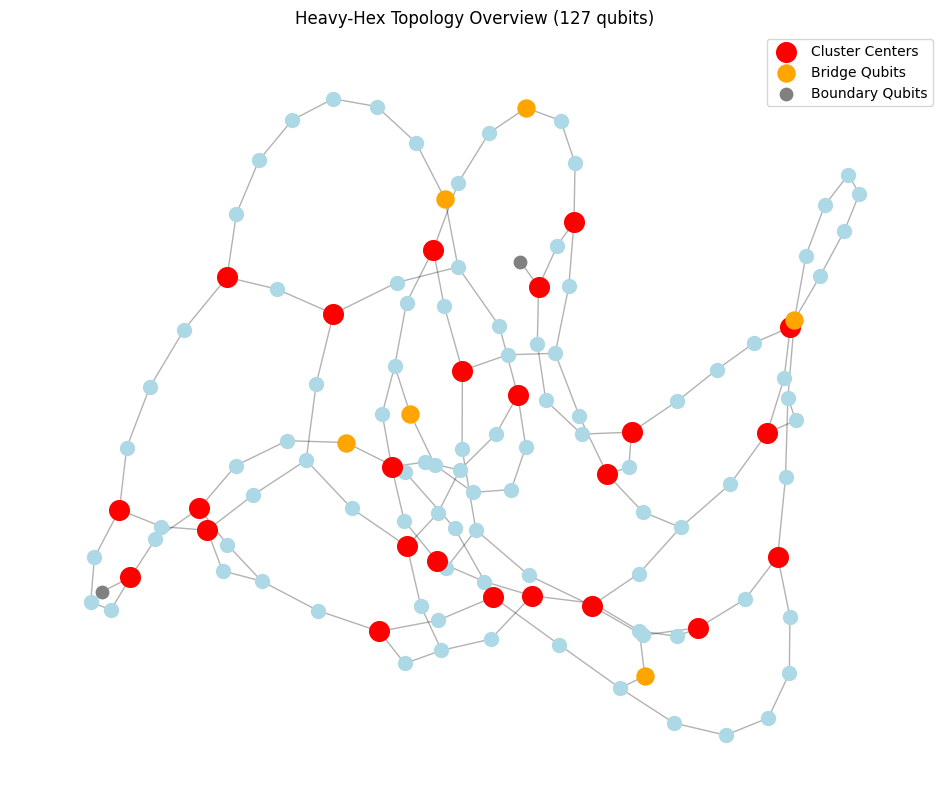

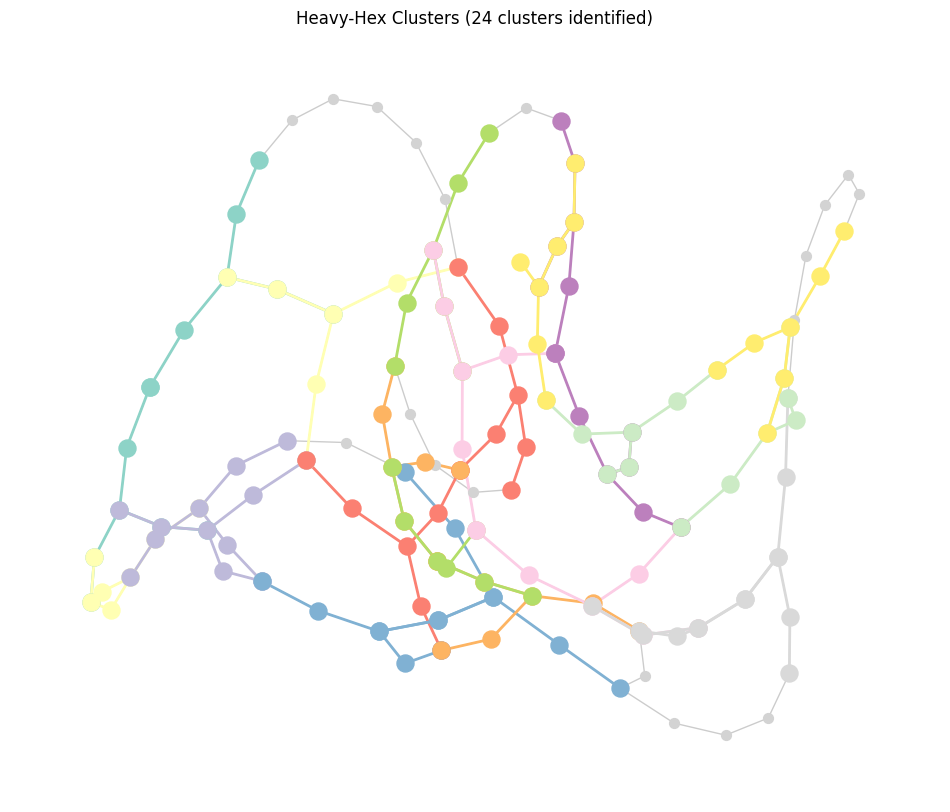

In [4]:
# Create topology visualizations
print("🎨 Creating topology visualizations...")

# Get special qubits and hex clusters
special_qubits = analysis_results['special_qubits']
hex_clusters = analysis_results['hex_clusters']

print(f"📈 Special Qubits Found:")
print(f"   Cluster centers: {special_qubits['cluster_centers']}")
print(f"   Bridge qubits: {special_qubits['bridge_qubits']}")
print(f"   Boundary qubits: {special_qubits['boundary_qubits']}")

if hex_clusters:
    print(f"\n🔶 Hex Clusters Found:")
    for i, cluster in enumerate(hex_clusters[:5]):  # Show first 5 clusters
        print(f"   Cluster {i+1}: {cluster}")
    if len(hex_clusters) > 5:
        print(f"   ... and {len(hex_clusters) - 5} more clusters")

# Create visualizations
try:
    figures = topology_analyzer.create_topology_visualizations()
    print(f"\n✅ Created {len(figures)} topology visualizations")
    print(f"   Available plots: {list(figures.keys())}")
    
    
except Exception as e:
    print(f"⚠️  Visualization creation failed: {e}")

print(f"\n🔧 Distance Matrix Available:")
distance_matrix = topology_analyzer.get_distance_matrix()
print(f"   Shape: {distance_matrix.shape}")
print(f"   Max distance: {np.max(distance_matrix[distance_matrix < np.inf]):.0f}")
print(f"   Avg distance: {np.mean(distance_matrix[distance_matrix < np.inf]):.2f}")

print(f"\n✅ Topology analysis complete and ready for layout optimization!")


## Test Circuit Creation

Create a sample circuit for testing the layout optimization:


In [13]:
# Create test circuit using CONFIG parameters 
circuit_sizes = config.get_circuit_sizes()
n_qubits = circuit_sizes[0]  # Use first size from config
depth = int(n_qubits * config.get_depth_factor())
seed = config.get_seed()

print(f"🎯 Creating circuit from config:")
print(f"   Active suite: {config.get_active_suite()}")
print(f"   Available sizes: {circuit_sizes}")
print(f"   Using: {n_qubits} qubits")
print(f"   Depth factor: {config.get_depth_factor()}")
print(f"   Seed: {seed}")

# Create circuit with config parameters
circuit = QuantumVolume(n_qubits, depth, seed=seed)

print(f"\nTest circuit: QV({n_qubits}, {depth})")
print(f"Number of qubits: {circuit.num_qubits}")
print(f"Circuit depth: {circuit.depth()}")
print(f"Gate counts: {circuit.count_ops()}")

# TODO: Once implementation is complete, uncomment below
# circuit.draw(output='mpl', fold=120)
# plt.show()

print(f"\n✅ Test circuit created from config successfully!")


🎯 Creating circuit from config:
   Active suite: quantum_volume
   Available sizes: [15, 25, 60]
   Using: 15 qubits
   Depth factor: 1.0
   Seed: 42

Test circuit: QV(15, 15)
Number of qubits: 15
Circuit depth: 1
Gate counts: OrderedDict([('quantum_volume_[15,15,42]', 1)])

✅ Test circuit created from config successfully!


In [8]:
# Import pipeline components
from pipeline.transpiler import TranspilerComparison
from pipeline.metrics import MetricsCollector

print("🚀 Running actual transpilation comparison...")
print(f"\nUsing config algorithm: {config.config['layout_optimization']['algorithm']}")
print(f"Baseline optimization level: {config.get_optimization_level()}")
print(f"Target CX reduction: {config.config['targets']['cx_reduction_target_percent']}%")

# Initialize the transpilation comparison engine
comparator = TranspilerComparison(backend)

# Initialize custom layout pass (currently a stub)
layout_pass = GreedyCommunityLayout(backend)  # Uses config seed automatically

print("\n🔄 Running transpilation comparison...")
print("=" * 50)

# Run the comparison on our test circuit
result = comparator.compare_transpilation(circuit, layout_pass)

# Display results
print(f"\n📊 Results for {result['circuit_name']}:")
print(f"   Input: {result['input_stats']['num_qubits']} qubits, {result['input_stats']['cx_count']} CX gates")

# Stock results
stock = result['stock']
print(f"\n📈 Stock transpilation (opt_level={config.get_optimization_level()}):")
print(f"   Success: {stock['success']}")
if stock['success']:
    print(f"   CX count: {stock['stats']['cx_count']}")
    print(f"   Circuit depth: {stock['stats']['depth']}")
    print(f"   Compile time: {stock['compile_time']:.3f}s")

# Custom results
custom = result['custom']
print(f"\n🎯 Custom layout transpilation:")
print(f"   Success: {custom['success'] if custom else False}")
if custom and custom['success']:
    print(f"   CX count: {custom['stats']['cx_count']}")
    print(f"   Circuit depth: {custom['stats']['depth']}")
    print(f"   Compile time: {custom['compile_time']:.3f}s")

# Comparison metrics
comparison = result['comparison']
if comparison and comparison['comparison_valid']:
    print(f"\n🏆 Performance Comparison:")
    print(f"   CX reduction: {comparison['cx_reduction_percent']:.1f}%")
    print(f"   Depth reduction: {comparison['depth_reduction_percent']:.1f}%")
    print(f"   Compile time ratio: {comparison['compile_time_ratio']:.2f}x")
    
    # Check if we met our target
    target = config.config['targets']['cx_reduction_target_percent']
    if comparison['cx_reduction_percent'] >= target:
        print(f"   ✅ TARGET MET: {comparison['cx_reduction_percent']:.1f}% ≥ {target}%")
    else:
        print(f"   ❌ Target missed: {comparison['cx_reduction_percent']:.1f}% < {target}%")
else:
    print(f"\n❌ Comparison failed - check error messages above")

print(f"\n✅ Transpilation comparison complete!")


🚀 Running actual transpilation comparison...

Using config algorithm: simple
Baseline optimization level: 3
Target CX reduction: 25.0%

🔄 Running transpilation comparison...
🔄 Running stock transpilation (opt_level=3)...
🔄 Running custom transpilation...
⚠️  Custom layout pass didn't set _layout, using standard transpile

📊 Results for quantum_volume_[15,15,42]:
   Input: 15 qubits, 0 CX gates

📈 Stock transpilation (opt_level=3):
   Success: True
   CX count: 639
   Circuit depth: 1096
   Compile time: 1.534s

🎯 Custom layout transpilation:
   Success: True
   CX count: 639
   Circuit depth: 1096
   Compile time: 1.359s

🏆 Performance Comparison:
   CX reduction: 0.0%
   Depth reduction: 0.0%
   Compile time ratio: 0.89x
   ❌ Target missed: 0.0% < 25.0%

✅ Transpilation comparison complete!


In [9]:
# Run full benchmark suite using CONFIG
print("🚀 Running benchmark suite from config...")
print(f"Active suite: {config.get_active_suite()}")
print(f"Circuit sizes: {config.get_circuit_sizes()}")

# Create circuits for all sizes in config
circuits = {}
for size in config.get_circuit_sizes():
    depth = int(size * config.get_depth_factor())
    qv_circuit = QuantumVolume(size, depth, seed=config.get_seed())
    circuits[f"QV_{size}q_{depth}d"] = qv_circuit

print(f"\nGenerated {len(circuits)} benchmark circuits")

# Run batch comparison
batch_results = comparator.batch_compare(circuits, layout_pass)

# Collect and analyze metrics
metrics_collector = MetricsCollector()
metrics_collector.collect_results(batch_results)

# Print comprehensive summary
metrics_collector.print_summary_report()

# Get scaling analysis
scaling_analysis = metrics_collector.get_size_scaling_analysis()
if 'error' not in scaling_analysis:
    print(f"\n📈 SCALING ANALYSIS:")
    print("-" * 40)
    for size_range, stats in scaling_analysis.items():
        print(f"{size_range}:")
        print(f"   Circuits: {stats['count']}")
        print(f"   Avg CX reduction: {stats['avg_cx_reduction']:.1f}%")
        print(f"   Improvement rate: {stats['improvement_rate']:.1f}%")
        print(f"   Best result: {stats['best_cx_reduction']:.1f}%")

# Export results
df = metrics_collector.get_metrics_dataframe()
if not df.empty:
    output_dir = config.get_output_directory()
    csv_file = output_dir / "benchmark_results.csv"
    df.to_csv(csv_file, index=False)
    print(f"\n💾 Results saved to: {csv_file}")

print(f"\n🎉 Benchmark suite complete!")


🚀 Running benchmark suite from config...
Active suite: quantum_volume
Circuit sizes: [15, 25, 60]

Generated 3 benchmark circuits
🚀 Starting batch comparison of 3 circuits...

[1/3] Processing QV_15q_15d...
🔄 Running stock transpilation (opt_level=3)...
🔄 Running custom transpilation...
⚠️  Custom layout pass didn't set _layout, using standard transpile
  ✅ CX reduction: 0.0%

[2/3] Processing QV_25q_25d...
🔄 Running stock transpilation (opt_level=3)...
🔄 Running custom transpilation...
⚠️  Custom layout pass didn't set _layout, using standard transpile
  ✅ CX reduction: 0.0%

[3/3] Processing QV_60q_60d...
🔄 Running stock transpilation (opt_level=3)...
🔄 Running custom transpilation...
⚠️  Custom layout pass didn't set _layout, using standard transpile
  ✅ CX reduction: 0.0%

🎉 Batch comparison complete!

📊 QUANTUM LAYOUT OPTIMIZATION RESULTS SUMMARY

📈 Overall Performance:
  Total circuits tested: 3
  Successful comparisons: 3
  Success rate: 100.0%

🎯 CX Gate Reduction:
  Average re